In [12]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [13]:
## Function to find large child contours in the frame and return the x,y coordinates and the frame in which the contour was found
def findChildContours(frame, frame_count):
    contours, hierarchy = cv2.findContours(frame, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    child_contours = []
    # Code taken from: https://stackoverflow.com/questions/22240746/recognize-open-and-closed-shapes-opencv
    hierarchy = hierarchy[0] 
    for i, c in enumerate(contours):
        # Return only innermost contours with no child contours 
        if hierarchy[i][2] < 0 and hierarchy[i][3] < 0:
            child_contours.append(c)
    x_coords = []
    y_coords = []
    size = []
    for c in child_contours:
        if cv2.contourArea(c) > 240: # Only save large contours # Originally 200
            m = cv2.moments(c)
            # Find Contour centre 
            x = m['m10'] / m['m00']
            y = m['m01'] / m['m00']
            x_coords.append(x)
            y_coords.append(y)
            size.append(cv2.contourArea(c))
    frame_counts = [frame_count] * len(x_coords) # Which frame these contours found in
    return list(zip(x_coords, y_coords, frame_counts)) # Zip lists to list of tuples # Size removed

cap = cv2.VideoCapture('../Bees10.mov')

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Type font for adding frame counter to video
font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,500)
fontScale              = 1
fontColor              = (255,255,255)
lineType               = 2

delay_time = 1 # Delay next loop for easier viewing
prev_frame = None 
# Save frames for isolated study
saved_frames = [] 
rois = list(np.arange(240,250))

counter = 0 # Frame counter
potential_waggles = [] # List to save potential waggles

while True:
    counter += 1
    ret, frame = cap.read()
#    frame = frame[300:600, 700:1050]

    # Our operations on the frame come here
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.GaussianBlur(gray, (21,21), 0)
    
    thresh = cv2.threshold(gray_blur, 108, 230, cv2.THRESH_BINARY)[1]
    
    # If first frame, set current frame as prev_frame
    if prev_frame is None:
        prev_frame = thresh
    current_frame = thresh

    frame_diff = cv2.absdiff(current_frame, prev_frame) # Background Subtraction    
    
    _, hierarchy = cv2.findContours(frame_diff, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    # Catch blank images and skip frame
    if hierarchy is None:
        continue
    else:
        find_waggles = findChildContours(frame_diff, counter)
        potential_waggles = potential_waggles + find_waggles
    
    # Frame Counter
    cv2.putText(thresh, str(counter), (40,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (150,0,0), 2)
    
    # Display the resulting frame
    cv2.imshow('Thresholded', thresh)
    cv2.imshow('Frame Diff', frame_diff)
    cv2.imshow('Grayscale', gray)
    cv2.imshow('GrayBlur', gray_blur)
    cv2.waitKey(delay_time)
    
    
    # Make current frame the previous frame for the next loop
    prev_frame = current_frame
    
    # q to quit
    if cv2.waitKey(delay_time) & 0xFF == ord('q'):
        break
    
    if counter in rois:
        saved_frames.append(frame_diff)
    
    if counter > 300:
        break
    
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1);

In [14]:
waggle_df = pd.DataFrame(potential_waggles, columns=['x', 'y', 'frame'])

In [15]:
from sklearn.cluster import DBSCAN

X = (potential_waggles)

clust1 = DBSCAN(eps=30, min_samples=8).fit(X)

waggle_df.loc[:, 'Cluster'] = clust1.labels_

# Manually calculate 'centroid' for each cluster (may be inaccurate if not convex)
# Code influecned by: https://stackoverflow.com/questions/23020659/fastest-way-to-calculate-the-centroid-of-a-set-of-coordinate-tuples-in-python-wi
cluster_labels = list(np.unique(clust1.labels_))
centroids = []
for i in cluster_labels:
    df = waggle_df[waggle_df['Cluster'] == i]
    l = len(df)
    x, y, z = np.sum(df.x), np.sum(df.y), np.sum(df.frame)
    centroid = (x/l, y/l, z/l)
    centroids.append(centroid)

# Create df of centroids list
roi_df = pd.DataFrame(centroids, columns=['x','y','frame'])
# Create x, y and frame range of roi
roi_df.loc[:, 'first frame'] = roi_df.frame - 30
roi_df.loc[:, 'final frame'] = roi_df.frame + 30
roi_df.loc[:, 'x0'] = roi_df.x - 100
roi_df.loc[:, 'x1'] = roi_df.x + 100
roi_df.loc[:, 'y0'] = roi_df.y - 100
roi_df.loc[:, 'y1'] = roi_df.y + 100
# Convert floats to int
roi_df = roi_df.astype(int)
# Negative frames if centroids are at start of video. Make 1 
roi_df.loc[roi_df['first frame'] < 0, 'first frame'] = 1
# Save first frames to a list for below while loop
roi_frames = roi_df['first frame'].values.tolist()

### Show scatter with cluster centroids for 300 frames for readability

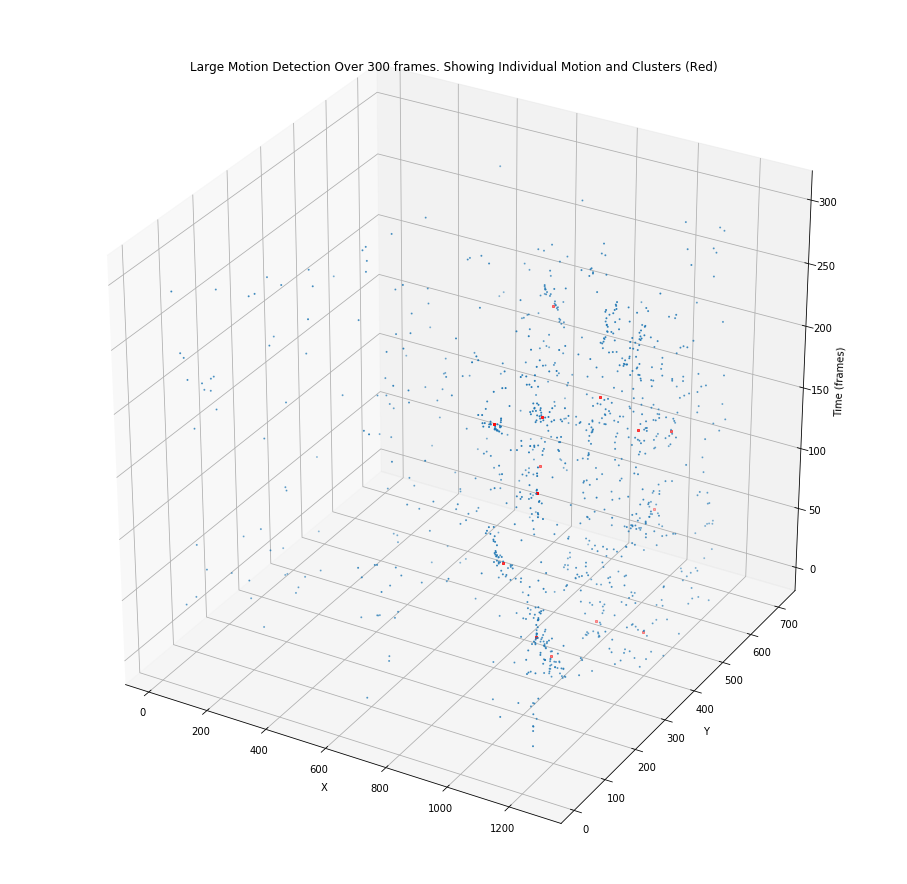

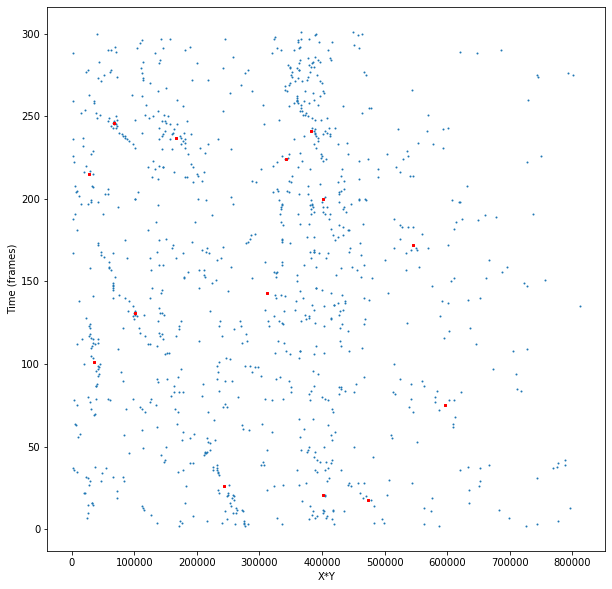

In [16]:
# scatter plot showing x,y and frames
from mpl_toolkits.mplot3d import Axes3D

#3d
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(waggle_df.x, waggle_df.y, waggle_df.frame, s=1)
ax.scatter(roi_df.x, roi_df.y, roi_df.frame, s=4, c='r', marker='s')
ax.set_title('Large Motion Detection Over 300 frames. Showing Individual Motion and Clusters (Red)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Time (frames)')

#2d
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
X = waggle_df.x * waggle_df.y
X_centroids = roi_df.x * roi_df.y
ax.scatter(X, waggle_df.frame, s=1)
ax.scatter(X_centroids, roi_df.frame, s=8, c='r', marker='s')
ax.set_xlabel('X*Y')
ax.set_ylabel('Time (frames)'); 

The above graph shows motion detection through time. Each point represents singular 'waggle-like' activity in a frame. A waggle run consists of several of these movements through frames in close proximity. Using density-based clustering via DBSCAN, waggle runs can be isolated. Waggle run detection is represented as the red plot points. These points are the 'centroid' of the waggle runs. 

### Demonstrate ROI Highlighting accuracy for the motion detector

The code below draws a box around the centroids found above, as an ROI. Within each box is a waggling bee, detected using the code above, albeit with some error which will be handled in successive code.

In [17]:
cap = cv2.VideoCapture('../Bees10.mov')

tracking_rois = []
counter = 0 
while True:
    counter += 1
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # if the counter reaches the first frame of an roi, return row index of roi
    if counter in roi_frames:
        i = roi_frames.index(counter)
        tracking_rois.append(i)
    
    for roi in tracking_rois:
        points = roi_df.iloc[roi, :]
        if points['final frame'] >= counter:
            cv2.rectangle(gray,pt1=(points.x0,points.y0),pt2=(points.x1,points.y1),color=(255,0,0),thickness=5)
        else:
            tracking_rois.remove(roi)

    # Frame Counter
    cv2.putText(gray, str(counter), (40,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (150,0,0), 2)
    cv2.imshow('Grayscale', gray)
    cv2.waitKey(40)
    
    if cv2.waitKey(40) & 0xFF == ord('q'):
        break
    
        
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1);

-1